In [1]:
!pip install qiskit
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 107.7 MB/s eta 0:00:00


In [2]:
# Deutsch Algorithm using Qiskit 2.x
# Compatible with Qiskit 2.0+ (2024–2025)

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator

# Choose the function type: 'constant_0', 'constant_1', 'balanced_0', 'balanced_1'
function_type = 'balanced_1'

def deutsch_oracle(qc, function_type):
    """Implements oracle Uf for given function type."""
    if function_type == 'constant_0':
        # f(x)=0 → Do nothing
        pass
    elif function_type == 'constant_1':
        # f(x)=1 → Apply X on the output qubit
        qc.x(1)
    elif function_type == 'balanced_0':
        # f(x)=x → Apply CNOT (control: input, target: output)
        qc.cx(0, 1)
    elif function_type == 'balanced_1':
        # f(x)=NOT(x) → Apply X, then CNOT, then X
        qc.x(0)
        qc.cx(0, 1)
        qc.x(0)

In [3]:
# Step 1: Initialize quantum circuit with 2 qubits and 1 classical bit
qc = QuantumCircuit(2, 1)

# Step 2: Initialize |x>|y> = |0>|1> and apply Hadamard
qc.x(1)             # Set output qubit to |1>
qc.barrier()
qc.h([0, 1])        # Apply Hadamard to both qubits

# Step 3: Apply the oracle
qc.barrier()
deutsch_oracle(qc, function_type)

In [4]:
# Step 4: Apply Hadamard to input qubit
qc.barrier()
qc.h(0)

# Step 5: Measure the first qubit
qc.measure(0, 0)

# Visualize circuit
print(qc.draw(output="text"))

           ░ ┌───┐ ░ ┌───┐     ┌───┐ ░ ┌───┐┌─┐
q_0: ──────░─┤ H ├─░─┤ X ├──■──┤ X ├─░─┤ H ├┤M├
     ┌───┐ ░ ├───┤ ░ └───┘┌─┴─┐└───┘ ░ └───┘└╥┘
q_1: ┤ X ├─░─┤ H ├─░──────┤ X ├──────░───────╫─
     └───┘ ░ └───┘ ░      └───┘      ░       ║ 
c: 1/════════════════════════════════════════╩═
                                             0 


In [5]:
# Step 6: Simulate
sim = AerSimulator()
qc_compiled = transpile(qc, sim)
result = sim.run(qc_compiled).result()
counts = result.get_counts()

print("\nMeasurement results:", counts)

# Interpret result
if list(counts.keys())[0] == '0':
    print("→ Function is CONSTANT.")
else:
    print("→ Function is BALANCED.")


Measurement results: {'1': 1024}
→ Function is BALANCED.


### Task 1

In [6]:
# Modify the oracle to implement f(x) = x XOR 1
def deutsch_oracle(qc, function_type):
    """Implements oracle Uf for given function type."""
    if function_type == 'constant_0':
        # f(x)=0 → Do nothing
        pass
    elif function_type == 'constant_1':
        # f(x)=1 → Apply X on the output qubit
        qc.x(1)
    elif function_type == 'balanced_0':
        # f(x)=x → Apply CNOT (control: input, target: output)
        qc.cx(0, 1)
    elif function_type == 'balanced_1':
        # f(x)=NOT(x) → Apply X, then CNOT, then X
        qc.x(0)
        qc.cx(0, 1)
        qc.x(0)
    elif function_type == 'xor_1': # New function f(x) = x XOR 1
        # f(0) = 0 XOR 1 = 1
        # f(1) = 1 XOR 1 = 0
        # This is equivalent to applying X to the output qubit if the input is 0,
        # and doing nothing if the input is 1.
        # This can be achieved with a CX with the control on the input qubit and target on the output,
        # followed by an X on the output qubit.
        qc.cx(0, 1)
        qc.x(1)

In [7]:
# Choose the new function type
function_type = 'xor_1'

# Step 1: Initialize quantum circuit with 2 qubits and 1 classical bit
qc = QuantumCircuit(2, 1)

# Step 2: Initialize |x>|y> = |0>|1> and apply Hadamard
qc.x(1)             # Set output qubit to |1>
qc.barrier()
qc.h([0, 1])        # Apply Hadamard to both qubits

# Step 3: Apply the oracle
qc.barrier()
deutsch_oracle(qc, function_type)

# Step 4: Apply Hadamard to input qubit
qc.barrier()
qc.h(0)

# Step 5: Measure the first qubit
qc.measure(0, 0)

# Visualize circuit
print(qc.draw(output="text"))

# Step 6: Simulate
sim = AerSimulator()
qc_compiled = transpile(qc, sim)
result = sim.run(qc_compiled).result()
counts = result.get_counts()

print("\nMeasurement results:", counts)

# Interpret result
if list(counts.keys())[0] == '0':
    print("→ Function is CONSTANT.")
else:
    print("→ Function is BALANCED.")

           ░ ┌───┐ ░            ░ ┌───┐┌─┐
q_0: ──────░─┤ H ├─░───■────────░─┤ H ├┤M├
     ┌───┐ ░ ├───┤ ░ ┌─┴─┐┌───┐ ░ └───┘└╥┘
q_1: ┤ X ├─░─┤ H ├─░─┤ X ├┤ X ├─░───────╫─
     └───┘ ░ └───┘ ░ └───┘└───┘ ░       ║ 
c: 1/═══════════════════════════════════╩═
                                        0 

Measurement results: {'1': 1024}
→ Function is BALANCED.


### Task 2

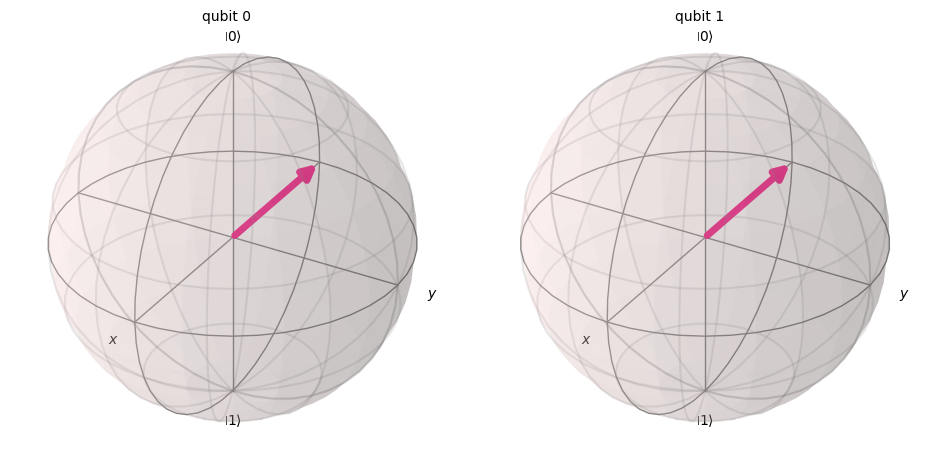

In [11]:
# Visualize state after applying the oracle (excluding final Hadamard and measurement)
qc_oracle = qc.copy()
# Remove the final Hadamard and measurement
qc_oracle.remove_final_measurements()
# The circuit 'qc' already has the oracle applied at this point, but includes
# the final Hadamard. We need to get the circuit state *after* the oracle
# and *before* the final Hadamard.
# Let's recreate the circuit up to the oracle application.

# Step 1: Initialize quantum circuit with 2 qubits and 1 classical bit
qc_oracle_viz = QuantumCircuit(2, 1)

# Step 2: Initialize |x>|y> = |0>|1> and apply Hadamard
qc_oracle_viz.x(1)             # Set output qubit to |1>
qc_oracle_viz.barrier()
qc_oracle_viz.h([0, 1])        # Apply Hadamard to both qubits

# Step 3: Apply the oracle
qc_oracle_viz.barrier()
# We need to use the correct function_type which was set to 'xor_1'
# We can get this from the previous cell or assume it's still in scope.
# If function_type is not in scope, we would need to re-define it or pass it.
# Assuming function_type 'xor_1' is still accessible.
deutsch_oracle(qc_oracle_viz, function_type)

display(plot_bloch_multivector(Statevector(qc_oracle_viz)))

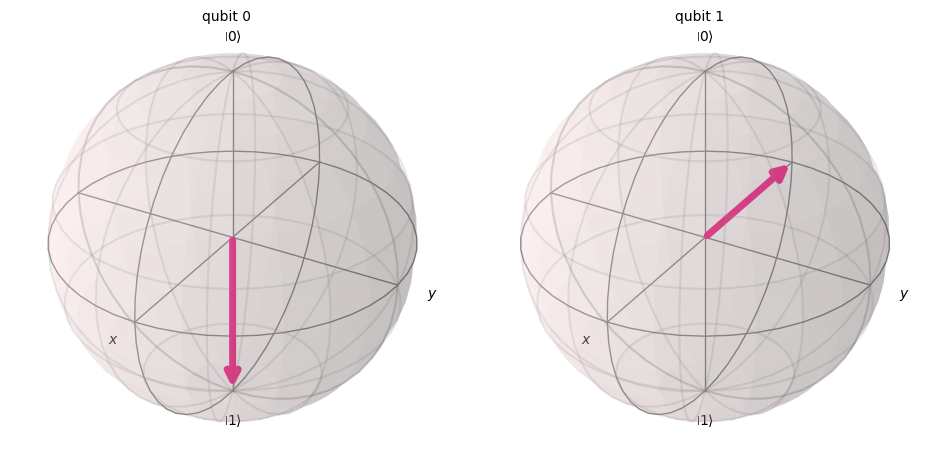

In [10]:
# Visualize state after applying Hadamard (excluding measurement)
qc_h = qc.copy()
qc_h.remove_final_measurements()
display(plot_bloch_multivector(Statevector(qc_h)))

### Task 3

In [12]:
def deutsch_jozsa_oracle_2qubit(qc, function_type):
    """Implements oracle Uf for given 2-qubit function type."""
    # qc is a QuantumCircuit object with at least 3 qubits (2 input, 1 output)
    # function_type can be 'constant_0', 'constant_1', 'balanced_0', 'balanced_1',
    # 'balanced_2', 'balanced_3'

    if function_type == 'constant_0':
        # f(x0, x1) = 0 --> Do nothing
        pass
    elif function_type == 'constant_1':
        # f(x0, x1) = 1 --> Apply X on the output qubit
        qc.x(2)
    elif function_type == 'balanced_0':
        # f(x0, x1) = x0 --> Apply CX on input qubit 0 and output qubit
        qc.cx(0, 2)
    elif function_type == 'balanced_1':
        # f(x0, x1) = x1 --> Apply CX on input qubit 1 and output qubit
        qc.cx(1, 2)
    elif function_type == 'balanced_2':
        # f(x0, x1) = x0 XOR x1 --> Apply CX(0, 2) and CX(1, 2)
        qc.cx(0, 2)
        qc.cx(1, 2)
    elif function_type == 'balanced_3':
        # f(x0, x1) = x0 XOR x1 XOR 1 --> Apply CX(0, 2), CX(1, 2), and X(2)
        qc.cx(0, 2)
        qc.cx(1, 2)
        qc.x(2)
    # We can add more balanced functions as needed

In [13]:
# Step 1: Initialize quantum circuit with 2 input qubits, 1 output qubit, and 2 classical bits
# We need 2 classical bits to measure the two input qubits
qc_dj = QuantumCircuit(3, 2)

# Step 2: Initialize the output qubit to |1> and apply Hadamard to all qubits
qc_dj.x(2)             # Set output qubit to |1>
qc_dj.barrier()
qc_dj.h([0, 1, 2])        # Apply Hadamard to all qubits (input and output)

# Visualize the circuit after initialization and initial Hadamards
print("Circuit after initialization and initial Hadamards:")
print(qc_dj.draw(output="text"))

Circuit after initialization and initial Hadamards:
           ░ ┌───┐
q_0: ──────░─┤ H ├
           ░ ├───┤
q_1: ──────░─┤ H ├
     ┌───┐ ░ ├───┤
q_2: ┤ X ├─░─┤ H ├
     └───┘ ░ └───┘
c: 2/═════════════
                  


In [14]:
# Step 3: Apply the oracle
qc_dj.barrier()

# Choose a 2-qubit function type (e.g., 'constant_0', 'constant_1', 'balanced_0', etc.)
function_type_dj = 'constant_0'
deutsch_jozsa_oracle_2qubit(qc_dj, function_type_dj)

# Visualize the circuit after applying the oracle
print("\nCircuit after applying the oracle ({}):".format(function_type_dj))
print(qc_dj.draw(output="text"))


Circuit after applying the oracle (constant_0):
           ░ ┌───┐ ░ 
q_0: ──────░─┤ H ├─░─
           ░ ├───┤ ░ 
q_1: ──────░─┤ H ├─░─
     ┌───┐ ░ ├───┤ ░ 
q_2: ┤ X ├─░─┤ H ├─░─
     └───┘ ░ └───┘ ░ 
c: 2/════════════════
                     


In [15]:
# Step 4: Apply Hadamard to the input qubits
qc_dj.barrier()
qc_dj.h([0, 1])

# Step 5: Measure the input qubits
qc_dj.measure([0, 1], [0, 1])

# Visualize the final circuit
print("\nFinal circuit:")
print(qc_dj.draw(output="text"))

# Step 6: Simulate
sim = AerSimulator()
qc_compiled_dj = transpile(qc_dj, sim)
result_dj = sim.run(qc_compiled_dj).result()
counts_dj = result_dj.get_counts()

print("\nMeasurement results:", counts_dj)

# Interpret result
# For Deutsch-Jozsa with n qubits, a constant function will result in all zeros
# in the measurement of the input qubits. A balanced function will result in
# at least one '1' in the measurement of the input qubits.
if '00' in counts_dj and len(counts_dj) == 1:
    print("→ Function is CONSTANT.")
else:
    print("→ Function is BALANCED.")


Final circuit:
           ░ ┌───┐ ░  ░ ┌───┐┌─┐   
q_0: ──────░─┤ H ├─░──░─┤ H ├┤M├───
           ░ ├───┤ ░  ░ ├───┤└╥┘┌─┐
q_1: ──────░─┤ H ├─░──░─┤ H ├─╫─┤M├
     ┌───┐ ░ ├───┤ ░  ░ └───┘ ║ └╥┘
q_2: ┤ X ├─░─┤ H ├─░──░───────╫──╫─
     └───┘ ░ └───┘ ░  ░       ║  ║ 
c: 2/═════════════════════════╩══╩═
                              0  1 

Measurement results: {'00': 1024}
→ Function is CONSTANT.


### Task 4


Measurement results with noise: {'01': 4, '10': 2, '00': 1018}

Ideal measurement results (from previous run): {'00': 1024}

Probability of ideal outcome ('00') with noise: 0.9941


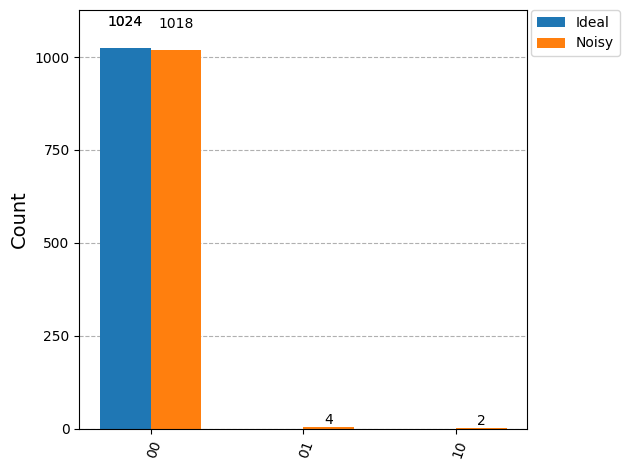

In [18]:
from qiskit_aer import AerSimulator
# from qiskit.transpiler.preset_passmanagers import optimize_level_2 # Removed
from qiskit import transpile # Correct import
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error

# Create a simple noise model
# This is a basic example, real noise models are more complex
noise_model = NoiseModel()

# Add depolarizing error to all single qubit gates
depolarizing_prob = 0.005
noise_model.add_all_qubit_quantum_error(depolarizing_error(depolarizing_prob, 1), ['u1', 'u2', 'u3', 'rz', 'sx', 'x']) # Removed 'cx'


# Add depolarizing error to all two qubit gates
noise_model.add_all_qubit_quantum_error(depolarizing_error(depolarizing_prob * 2, 2), ['cx'])

# Add thermal relaxation error to all qubits
# T1 and T2 relaxation times in nanoseconds
t1 = 100000 # 100 us
t2 = 80000  # 80 us
# Gate times in nanoseconds
gate_time_1q = 100 # 0.1 us
gate_time_2q = 500 # 0.5 us

# noise_model.add_all_qubit_runtime_error(thermal_relaxation_error(t1, t2, gate_time_1q), ['u1', 'u2', 'u3', 'rz', 'sx', 'x'])
# noise_model.add_all_qubit_runtime_error(thermal_relaxation_error(t1, t2, gate_time_2q), ['cx'])


# Create an Aer simulator with the noise model
sim_noise = AerSimulator(noise_model=noise_model)

# The Deutsch-Jozsa circuit we created earlier is stored in qc_dj

# Transpile the circuit for the noisy simulator
# Using optimization level 2 to potentially reduce circuit depth and mitigate noise effects
qc_compiled_noise = transpile(qc_dj, sim_noise, optimization_level=2) # Modified transpile call


# Run the noisy simulation
result_noise = sim_noise.run(qc_compiled_noise).result()
counts_noise = result_noise.get_counts()

print("\nMeasurement results with noise:", counts_noise)

# Analyze the impact of noise
# In the ideal case for a constant function, we expect only '00'.
# With noise, we might see other outcomes with small probabilities.
# We can compare the results to the ideal case (which we got from the previous simulation)

print("\nIdeal measurement results (from previous run):", counts_dj)

# You can further analyze the difference, e.g., calculate the probability of getting the ideal outcome
ideal_outcome = '00' if ('00' in counts_dj and len(counts_dj) == 1) else 'balanced_outcome(s)' # Simple check based on previous output
total_shots = sum(counts_noise.values())

if ideal_outcome in counts_noise:
    probability_ideal_with_noise = counts_noise[ideal_outcome] / total_shots
    print(f"\nProbability of ideal outcome ('{ideal_outcome}') with noise: {probability_ideal_with_noise:.4f}")
else:
     print(f"\nIdeal outcome ('{ideal_outcome}') not observed in noisy simulation.")

# You can also visualize the noisy results as a histogram and compare to the ideal
from qiskit.visualization import plot_histogram
display(plot_histogram([counts_dj, counts_noise], legend=['Ideal', 'Noisy']))

### Task 5

In [19]:
# Implement a classical function evaluator for 1-qubit functions
def classical_function_1qubit(x, function_type):
    """Classically evaluates a 1-qubit function."""
    if function_type == 'constant_0':
        return 0
    elif function_type == 'constant_1':
        return 1
    elif function_type == 'balanced_0': # f(x) = x
        return x
    elif function_type == 'balanced_1': # f(x) = NOT(x)
        return 1 - x
    elif function_type == 'xor_1': # f(x) = x XOR 1
        return x ^ 1
    else:
        raise ValueError("Invalid function type for 1-qubit function.")

# Implement a classical function evaluator for 2-qubit functions
def classical_function_2qubit(x0, x1, function_type):
    """Classically evaluates a 2-qubit function."""
    if function_type == 'constant_0':
        return 0
    elif function_type == 'constant_1':
        return 1
    elif function_type == 'balanced_0': # f(x0, x1) = x0
        return x0
    elif function_type == 'balanced_1': # f(x0, x1) = x1
        return x1
    elif function_type == 'balanced_2': # f(x0, x1) = x0 XOR x1
        return x0 ^ x1
    elif function_type == 'balanced_3': # f(x0, x1) = x0 XOR x1 XOR 1
        return x0 ^ x1 ^ 1
    else:
        raise ValueError("Invalid function type for 2-qubit function.")

# Example usage (optional)
# print("Classical f(0) for constant_0:", classical_function_1qubit(0, 'constant_0'))
# print("Classical f(1) for balanced_1:", classical_function_1qubit(1, 'balanced_1'))
# print("Classical f(0, 1) for balanced_2:", classical_function_2qubit(0, 1, 'balanced_2'))

In [20]:
def classify_function_classically_1qubit(function_type):
    """Classically classifies a 1-qubit function as constant or balanced."""
    query_count = 0
    # To determine if a 1-qubit function is constant or balanced classically,
    # we need to evaluate it for both inputs: 0 and 1.

    # Query for input 0
    output_0 = classical_function_1qubit(0, function_type)
    query_count += 1

    # Query for input 1
    output_1 = classical_function_1qubit(1, function_type)
    query_count += 1

    print(f"Classical evaluation for 1-qubit function '{function_type}':")
    print(f"f(0) = {output_0}")
    print(f"f(1) = {output_1}")
    print(f"Classical queries needed: {query_count}")

    if output_0 == output_1:
        print("→ Function is CONSTANT.")
    else:
        print("→ Function is BALANCED.")

    return query_count

def classify_function_classically_2qubit(function_type):
    """Classically classifies a 2-qubit function as constant or balanced."""
    query_count = 0
    # To determine if a 2-qubit function is constant or balanced classically,
    # in the worst case, we need to evaluate it for more than half of the possible inputs.
    # For 2 inputs, there are 2^2 = 4 possible inputs (00, 01, 10, 11).
    # We need to evaluate at least 3 inputs to be sure if it's constant or balanced.
    # If the first two outputs are different, it's balanced.
    # If the first two are the same, we need a third query. If the third is different, it's balanced.
    # If all three are the same, it's constant.

    inputs = [(0, 0), (0, 1), (1, 0), (1, 1)]
    outputs = []

    # Query for input (0, 0)
    output_00 = classical_function_2qubit(0, 0, function_type)
    outputs.append(output_00)
    query_count += 1

    # Query for input (0, 1)
    output_01 = classical_function_2qubit(0, 1, function_type)
    outputs.append(output_01)
    query_count += 1

    print(f"Classical evaluation for 2-qubit function '{function_type}':")
    print(f"f(0, 0) = {output_00}")
    print(f"f(0, 1) = {output_01}")

    if output_00 != output_01:
        print("Classical queries needed: 2")
        print("→ Function is BALANCED.")
        return query_count # 2 queries needed

    # If output_00 == output_01, we need at least one more query
    # Query for input (1, 0)
    output_10 = classical_function_2qubit(1, 0, function_type)
    outputs.append(output_10)
    query_count += 1
    print(f"f(1, 0) = {output_10}")

    if output_10 != output_00:
        print("Classical queries needed: 3")
        print("→ Function is BALANCED.")
        return query_count # 3 queries needed

    # If output_10 == output_00, we need one more query in the worst case
    # Query for input (1, 1)
    output_11 = classical_function_2qubit(1, 1, function_type)
    outputs.append(output_11)
    query_count += 1
    print(f"f(1, 1) = {output_11}")


    # After 4 queries, we can definitively say
    print(f"Classical queries needed: {query_count}")
    if len(set(outputs)) == 1:
         print("→ Function is CONSTANT.")
    else:
        print("→ Function is BALANCED.")

    return query_count


# Example usage:
# classical_queries_1q_constant = classify_function_classically_1qubit('constant_0')
# classical_queries_1q_balanced = classify_function_classically_1qubit('balanced_1')
# classical_queries_2q_constant = classify_function_classically_2qubit('constant_0')
# classical_queries_2q_balanced = classify_function_classically_2qubit('balanced_2')

### Comparing Classical and Quantum Queries

For a 1-qubit function:
*   The classical algorithm requires at least 2 queries (evaluating $f(0)$ and $f(1)$) to determine if the function is constant or balanced in the worst case.
*   The quantum Deutsch algorithm requires only **1** query to the oracle (the quantum function evaluator) to determine if the function is constant or balanced.

For a 2-qubit function:
*   The classical algorithm requires up to $2^{2-1} + 1 = 3$ queries in the worst case to determine if the function is constant or balanced. In the worst-case for $n$ qubits, it requires $2^{n-1} + 1$ queries.
*   The quantum Deutsch-Jozsa algorithm requires only **1** query to the oracle (the quantum function evaluator) to determine if the function is constant or balanced.

This demonstrates the power of quantum computation for certain problems. In this specific case, the Deutsch and Deutsch-Jozsa algorithms provide a significant speedup in terms of the number of queries required compared to any classical algorithm.